***Explainable Machine Learning for Credit Risk Prediction in Digital Lending: A Comparative Study Using SHAP***

**Step 0 : Install extra libraries**






In [3]:
# STEP 0: Install extra libraries (run once when freshly loaded)

!pip install xgboost shap catboost -q


**Step 1 – Imports, mount Drive, load data**

In [4]:
# STEP 1: Imports all the neccessary libraries

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, classification_report

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

import shap

pd.set_option('display.max_columns', None)

# Load data
file_path = '/content/drive/MyDrive/Dissertation/lendingclub_sample_100k_raw.csv'
df = pd.read_csv(file_path)

# Quick checks
print("Original shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print("\nColumn names:")
print(df.columns.tolist())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original shape: (100000, 152)

First 5 rows:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,target
0,105173463,NaN,19425.0,19425.0,19425.0,60 months,16.99,482.66,D,D1,RN Case Manager,1 year,RENT,62000.0,Not Verified,Apr-2017,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,Home improvement,560xx,MN,31.75,0.0,Mar-2005,695.0,699.0,0.0,63.0,NaN,11.0,0.0,21562.0,91.0,23.0,w,0.0,0.0,24538.248774,24538.25,19425.00,5113.25,0.0,0.0,0.0,Dec-2018,15312.70,NaN,Jan-2019,719.0,715.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,275388.0,0.0,5.0,0.0,1.0,13.0,60808.0,53.0,0.0,0.0,15178.0,70.0,23700.0,0.0,0.0,0.0,5.0,25035.0,1038.0,95.4,0.0,0.0,145.0,89.0,36.0,13.0,4.0,36.0,NaN,NaN,66.0,0.0,2.0,2.0,2.0,2.0,14.0,4.0,5.0,2.0,11.0,0.0,0.0,0.0,0.0,91.3,100.0,0.0,0.0,295173.0,82370.0,22600.0,70524.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,474725,NaN,12000.0,12000.0,11875.0,36 months,15.31,417.79,D,D3,sportmode,2 years,RENT,60000.0,Not Verified,Jan-2010,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Creative Rights Expansion,926xx,CA,14.30,0.0,Jul-2003,730.0,734.0,0.0,NaN,NaN,13.0,0.0,19068.0,89.9,16.0,f,0.0,0.0,14218.212655,14070.11,12000.00,2218.22,0.0,0.0,0.0,Nov-2011,1060.13,NaN,Mar-2019,719.0,715.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Column names:
['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'a

**Step 2 – Dropping leak & non-informative features**

* These are columns that “cheat” by using future repayment info or are just IDs/text not useful.

In [5]:
# 2.1 Leakage columns
leakage_cols = [
    # Repayment progress columns
    'out_prncp', 'out_prncp_inv',
    'total_pymnt', 'total_pymnt_inv',
    'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
    'recoveries', 'collection_recovery_fee',

    # Payment date/amount history
    'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
    'last_fico_range_high', 'last_fico_range_low',

    # Hardship and settlement fields
    'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status',
    'deferral_term', 'hardship_amount', 'hardship_start_date',
    'hardship_end_date', 'payment_plan_start_date', 'hardship_length',
    'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest',
    'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
    'debt_settlement_flag', 'debt_settlement_flag_date', 'settlement_status',
    'settlement_date', 'settlement_amount', 'settlement_percentage', 'settlement_term'
]

df_clean = df.drop(columns=leakage_cols, errors='ignore')

print("Shape after dropping leakage cols:", df_clean.shape)

# 2.2 Drop non-informative ID/text columns
non_informative_cols = [
    'id', 'member_id', 'url', 'desc', 'title', 'zip_code'
]

df_clean = df_clean.drop(columns=non_informative_cols, errors='ignore')

print("Shape after dropping non-informative cols:", df_clean.shape)
print("\nRemaining columns (first 30):")
print(df_clean.columns.tolist()[:30])


Shape after dropping leakage cols: (100000, 115)
Shape after dropping non-informative cols: (100000, 109)

Remaining columns (first 30):
['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util']


**Step 3 – Missing values preview & dropping extreme missing columns**

In [6]:
# Check missing values and drop very-high-missing columns

missing_ratio = df_clean.isnull().mean().sort_values(ascending=False)
print("Top 20 columns by missing ratio:")
display(missing_ratio.head(20))

# Dropping the  columns with > 80% missing data
to_drop = missing_ratio[missing_ratio > 0.80].index
print("\nDropping columns with >80% missing:", list(to_drop))

df_clean = df_clean.drop(columns=to_drop, errors='ignore')

print("Shape after dropping >80% missing columns:", df_clean.shape)


Top 20 columns by missing ratio:


,0
sec_app_mths_since_last_major_derog,0.99382
sec_app_revol_util,0.98438
revol_bal_joint,0.98411
sec_app_open_act_il,0.98411
sec_app_fico_range_low,0.98411
sec_app_chargeoff_within_12_mths,0.98411
sec_app_num_rev_accts,0.98411
sec_app_open_acc,0.98411
sec_app_mort_acc,0.98411
sec_app_inq_last_6mths,0.98411



Dropping columns with >80% missing: ['sec_app_mths_since_last_major_derog', 'sec_app_revol_util', 'revol_bal_joint', 'sec_app_open_act_il', 'sec_app_fico_range_low', 'sec_app_chargeoff_within_12_mths', 'sec_app_num_rev_accts', 'sec_app_open_acc', 'sec_app_mort_acc', 'sec_app_inq_last_6mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'verification_status_joint', 'annual_inc_joint', 'dti_joint', 'mths_since_last_record']
Shape after dropping >80% missing columns: (100000, 92)


In [7]:
# additional high-missing technical columns identified

high_missing = [
    'mths_since_last_major_derog', 'il_util', 'all_util',
    'open_acc_6m', 'open_il_24m', 'inq_fi', 'total_cu_tl'
]
df_clean = df_clean.drop(columns=[c for c in high_missing if c in df_clean.columns])

print("Shape after dropping additional high-missing columns:", df_clean.shape)


Shape after dropping additional high-missing columns: (100000, 85)


**Step 4 – Quick numeric & categorical EDA**

Numeric summary:


,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_act_il,open_il_12m,mths_since_rcnt_il,total_bal_il,open_rv_12m,open_rv_24m,max_bal_bc,total_rev_hi_lim,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,target
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,99975.000000,100000.000000,100000.000000,100000.000000,100000.000000,49409.000000,100000.000000,100000.00000,1.000000e+05,99920.000000,100000.00000,99994.000000,100000.0,100000.000000,9.495500e+04,9.495500e+04,40897.000000,40897.000000,39760.000000,40897.000000,40897.000000,40897.000000,40897.000000,9.495500e+04,40897.000000,96509.000000,94952.000000,95422.000000,95354.000000,99994.000000,100000.000000,92143.000000,94955.000000,94955.000000,94955.000000,96509.000000,95504.000000,23735.000000,87115.000000,33365.000000,94955.000000,94955.000000,94955.000000,95880.000000,94955.000000,94955.000000,94955.00000,94955.000000,94955.000000,95880.000000,91209.000000,94955.000000,94955.000000,94955.000000,94940.000000,95393.000000,99954.000000,99996.000000,9.495500e+04,9.650900e+04,96509.00000,9.495500e+04,100000.000000
mean,14510.038000,14501.082000,14479.424878,13.277336,440.955718,7.619894e+04,18.315069,0.316570,696.254700,700.254770,0.655650,34.310753,11.585850,0.21718,1.632156e+04,51.717917,24.94763,0.017481,1.0,0.005350,2.869712e+02,1.416157e+05,2.778346,0.775876,19.679427,35938.794973,1.415703,3.016040,5520.634056,3.286648e+04,2.323227,4.714876,13567.498494,10182.467555,59.813706,0.008471,17.685230,125.595585,180.918003,13.119720,7.838524,1.667357,23.913511,39.640362,6.673041,35.772516,0.505102,3.627950,5.626476,4.723915,8.070065,8.565700,8.26799,14.581412,5.575115,11.631247,0.000965,0.003539,0.086978,2.179432,94.185137,44.971349,0.134872,0.052962,1.750658e+05,4.999758e+04,21585.67975,4.248988e+04,0.212220
std,8751.828687,8748.531006,8750.829869,4.799278,262.974282,5.879772e+04,10.789224,0.863517,31.833007,31.833336,0.935618,21.951394,5.512032,0.62995,2.410289e+04,24.569988,12.04861,0.145451,0.0,0.078495,2.022705e+04,1.598725e+05,2.958386,0.991820,25.058474,43112.969796,1.569666,2.702669,5270.432677,3.494124e+04,2.550786,3.194798,16450.376552,15155.434896,28.341662,0.104494,866.535153,52.363184,94.539491,16.435912,8.697072,1.998212,30.989751,22.779931,5.847660,22.467347,1.306674,2.243681,3.311053,2.959361,4.791817,7.373273,4.58614,8.152966,3.229846,5.523229,0.031398,0.063660,0.483838,1.843547,8.720281,36.080948,0.375865,0.436972,1.836111e+05,4.889132e+04,21387.97990,4.373002e+04,0.408882
min,725.000000,725.000000,0.000000,5.310000,22.510000,0.000000e+00,0.000000,0.000000,660.000000,664.000000,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000,2.00000,0.000000,1.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.00000,0.000000e+00,0.

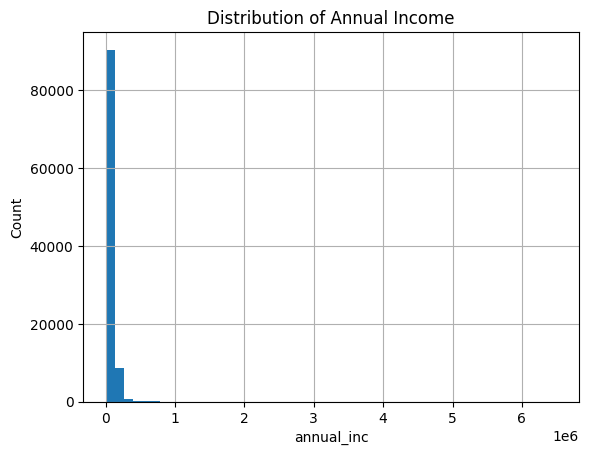

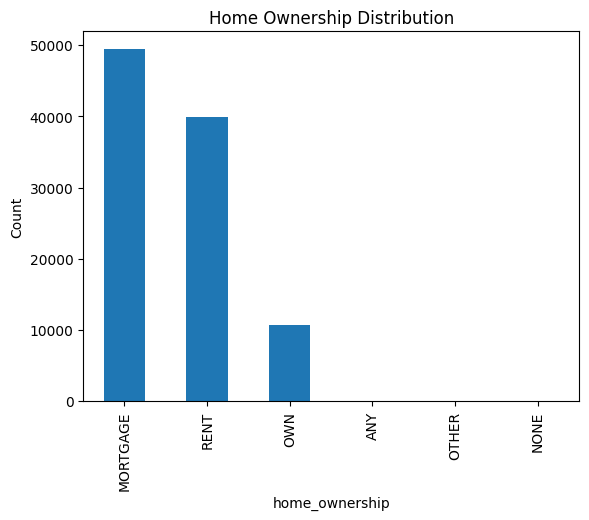

In [8]:
# Quick numeric overview

print("Numeric summary:")
display(df_clean.describe())

# Simple distribution plot for annual income (if it exist in data)
if 'annual_inc' in df_clean.columns:
    df_clean['annual_inc'].hist(bins=50)
    plt.title('Distribution of Annual Income')
    plt.xlabel('annual_inc')
    plt.ylabel('Count')
    plt.show()

# bar plot for home ownership
if 'home_ownership' in df_clean.columns:
    df_clean['home_ownership'].value_counts().plot(kind='bar')
    plt.title('Home Ownership Distribution')
    plt.xlabel('home_ownership')
    plt.ylabel('Count')
    plt.show()


**Step 5 – Handle outliers (dti & annual_inc)**

In [9]:
# Outlier handling (DTI (debt to income) & annual income)

if 'dti' in df_clean.columns:
    print("DTI stats before capping:")
    display(df_clean['dti'].describe())

    # cap at 60
    df_clean['dti'] = np.where(df_clean['dti'] > 60, 60, df_clean['dti'])
    # keeping only at [0,60]
    df_clean = df_clean[(df_clean['dti'] >= 0) & (df_clean['dti'] <= 60)]

    print("\nDTI stats after capping and filtering:")
    display(df_clean['dti'].describe())

if 'annual_inc' in df_clean.columns:
    print("\nAnnual_inc stats before capping:")
    display(df_clean['annual_inc'].describe())

    # cap at 500k and remove all negatives values
    df_clean['annual_inc'] = np.where(df_clean['annual_inc'] > 500000, 500000, df_clean['annual_inc'])
    df_clean = df_clean[df_clean['annual_inc'] >= 0]

    print("\nAnnual_inc stats after capping and filtering:")
    display(df_clean['annual_inc'].describe())

print("\nShape after outlier handling:", df_clean.shape)


DTI stats before capping:


,dti
count,99975.000000
mean,18.315069
std,10.789224
min,0.000000
25%,11.790000
50%,17.600000
75%,24.110000
max,999.000000



DTI stats after capping and filtering:


,dti
count,99975.000000
mean,18.226572
std,8.713101
min,0.000000
25%,11.790000
50%,17.600000
75%,24.110000
max,60.000000



Annual_inc stats before capping:


,annual_inc
count,9.997500e+04
mean,7.621799e+04
std,5.879273e+04
min,3.900000e+01
25%,4.590000e+04
50%,6.500000e+04
75%,9.083150e+04
max,6.500000e+06



Annual_inc stats after capping and filtering:


,annual_inc
count,99975.000000
mean,75828.645333
std,48138.333552
min,39.000000
25%,45900.000000
50%,65000.000000
75%,90831.500000
max,500000.000000



Shape after outlier handling: (99975, 85)


**Step 6 – Create binary target from loan_status**

In [10]:
# Creating binary target from loan_status

print("loan_status value counts:")
print(df_clean['loan_status'].value_counts())

# Defining what is "good" vs "bad" (tweak if needed based on your data)
good_statuses = [
    'Fully Paid', 'Current', 'In Grace Period',
    'Does not meet the credit policy. Status:Fully Paid'
]

bad_statuses = [
    'Charged Off', 'Default',
    'Late (31-120 days)', 'Late (16-30 days)',
    'Does not meet the credit policy. Status:Charged Off'
]

# Keeping only rows where status is clearly good or bad
mask = df_clean['loan_status'].isin(good_statuses + bad_statuses)
df_model = df_clean[mask].copy()

print("\nShape after filtering to good/bad statuses:", df_model.shape)

# Creating target: 1 = bad (default), 0 = good
df_model['target'] = np.where(df_model['loan_status'].isin(bad_statuses), 1, 0)

print("\nTarget value counts:")
print(df_model['target'].value_counts())


loan_status value counts:
loan_status
Fully Paid            78759
Charged Off           19646
Late (31-120 days)     1569
Default                   1
Name: count, dtype: int64

Shape after filtering to good/bad statuses: (99975, 85)

Target value counts:
target
0    78759
1    21216
Name: count, dtype: int64


**Step 7 – Handle missing values (numeric & categorical)**

In [11]:
# Handling remaining missing values in df_model

print("Missing values (top 20) BEFORE imputation:")
display(df_model.isnull().mean().sort_values(ascending=False).head(20))

# Example: some "months since" columns set to 0 if missing
for col in ['mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'mths_since_rcnt_il']:
    if col in df_model.columns:
        df_model[col] = df_model[col].fillna(0)

# Categorical columns: filling it with 'Unknown'
cat_cols = df_model.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    if col != 'loan_status':  # we'll drop loan_status soon anyway
        df_model[col] = df_model[col].fillna('Unknown')

# Numeric columns: filling it with median
num_cols = df_model.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != 'target']  # don't touch target

df_model[num_cols] = df_model[num_cols].fillna(df_model[num_cols].median())

print("\nMissing values (top 20) AFTER imputation:")
display(df_model.isnull().mean().sort_values(ascending=False).head(20))

print("\nShape after missing-value handling:", df_model.shape)


Missing values (top 20) BEFORE imputation:


,0
mths_since_recent_bc_dlq,0.762631
mths_since_recent_revol_delinq,0.666317
mths_since_rcnt_il,0.602531
inq_last_12m,0.591178
total_bal_il,0.591178
max_bal_bc,0.591178
open_rv_24m,0.591178
open_il_12m,0.591178
open_act_il,0.591178
open_rv_12m,0.591178



Missing values (top 20) AFTER imputation:


,0
loan_amnt,0.0
funded_amnt,0.0
funded_amnt_inv,0.0
term,0.0
int_rate,0.0
installment,0.0
grade,0.0
sub_grade,0.0
emp_title,0.0
emp_length,0.0



Shape after missing-value handling: (99975, 85)


**Step 8 – Encode categorical variables**

* We had both ordinal (grade, sub_grade, emp_length, term) and nominal columns. We’ll label-encode the ordinal ones and one-hot encode the rest.

In [12]:
# STEP 8: Encoding categorical features

# 8.1 Ordinal columns: grade, sub_grade, emp_length, term
ordinal_cols = ['grade', 'sub_grade', 'emp_length', 'term']
for col in ordinal_cols:
    if col in df_model.columns:
        df_model[col] = LabelEncoder().fit_transform(df_model[col].astype(str))

# 8.2 One-hot encoding nominal categorical variables
one_hot_cols = [
    'home_ownership',
    'verification_status',
    'purpose',
    'addr_state',
    'initial_list_status',
    'application_type',
    'disbursement_method',
    'pymnt_plan'
]

# Keeping only columns that actually exist
one_hot_cols = [c for c in one_hot_cols if c in df_model.columns]

df_encoded = pd.get_dummies(df_model, columns=one_hot_cols, drop_first=True)

print("Shape after one-hot encoding:", df_encoded.shape)
print("First 10 columns:")
print(df_encoded.columns.tolist()[:10])

# Dropping columns not useful or now redundant
cols_to_drop = ['emp_title', 'loan_status', 'issue_d', 'earliest_cr_line']
df_encoded = df_encoded.drop(columns=[c for c in cols_to_drop if c in df_encoded.columns], errors='ignore')

print("\nShape after dropping extra text/date columns:", df_encoded.shape)

# Checking for any remaining non-numeric columns
non_numeric = df_encoded.select_dtypes(include='object').columns
print("\nNon-numeric columns remaining:", list(non_numeric))


Shape after one-hot encoding: (99975, 150)
First 10 columns:
['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length']

Shape after dropping extra text/date columns: (99975, 146)

Non-numeric columns remaining: []


**Step 9 – Final quick check on target distribution**

Target distribution:
target
0    78759
1    21216
Name: count, dtype: int64


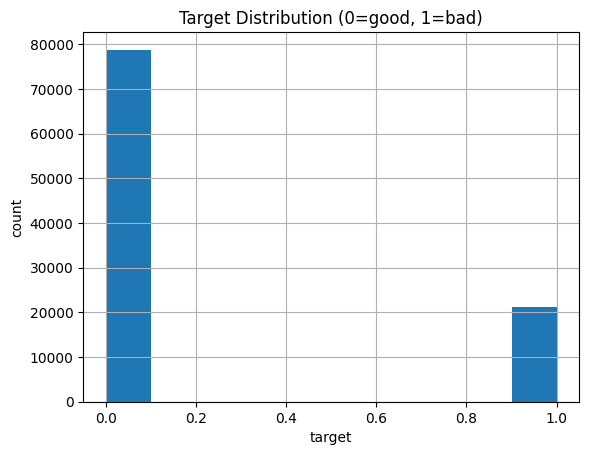


Final dataset shape (rows, columns): (99975, 146)


In [13]:
# Final target checking

print("Target distribution:")
print(df_encoded['target'].value_counts())

df_encoded['target'].hist()
plt.title('Target Distribution (0=good, 1=bad)')
plt.xlabel('target')
plt.ylabel('count')
plt.show()

print("\nFinal dataset shape (rows, columns):", df_encoded.shape)


**Step 10 – Train–test split**

In [14]:
# Train-test split

X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train value counts:")
print(y_train.value_counts(normalize=True))
print("\ny_test value counts:")
print(y_test.value_counts(normalize=True))


X_train shape: (79980, 145)
X_test shape: (19995, 145)
y_train value counts:
target
0    0.787784
1    0.212216
Name: proportion, dtype: float64

y_test value counts:
target
0    0.787797
1    0.212203
Name: proportion, dtype: float64


**Step 11 – Training 3 models (LogReg, RandomForest, XGBoost, CatBoost)**

In [15]:
# Train baseline models

models = {}

# 1) Logistic Regression (simple linear model)
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)
log_reg.fit(X_train, y_train)
models['LogisticRegression'] = log_reg

# 2) Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
models['RandomForest'] = rf

# 3) XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
models['XGBoost'] = xgb

# 4) CatBoost (optional – good with categorical, but we already encoded)
cb = CatBoostClassifier(
    iterations=300,
    depth=5,
    learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=False,
    random_seed=42
)
cb.fit(X_train, y_train)
models['CatBoost'] = cb

print("Models trained:", list(models.keys()))


Models trained: ['LogisticRegression', 'RandomForest', 'XGBoost', 'CatBoost']


**Step 12 – Evaluate models (Accuracy, ROC-AUC, F1)**

In [16]:
# Evaluating models on test set

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # fallback for models that don't have predict_proba (not the case here, but just in case)
        y_proba = y_pred

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)

    results.append((name, acc, auc, f1))

    print(f"\n{name} performance:")
    print("Accuracy:", acc)
    print("ROC-AUC:", auc)
    print("F1-score:", f1)
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))

# Putting results in a DataFrame for easy viewing
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'ROC_AUC', 'F1'])
print("\nSummary of models:")
display(results_df.sort_values(by='ROC_AUC', ascending=False))



LogisticRegression performance:
Accuracy: 0.7878469617404351
ROC-AUC: 0.6442283361703385
F1-score: 0.013029315960912053

Classification report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     15752
           1       0.51      0.01      0.01      4243

    accuracy                           0.79     19995
   macro avg       0.65      0.50      0.45     19995
weighted avg       0.73      0.79      0.70     19995


RandomForest performance:
Accuracy: 0.7943485871467867
ROC-AUC: 0.7195249933359004
F1-score: 0.1419031719532554

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.88     15752
           1       0.62      0.08      0.14      4243

    accuracy                           0.79     19995
   macro avg       0.71      0.53      0.51     19995
weighted avg       0.76      0.79      0.73     19995


XGBoost performance:
Accuracy: 0.7975993998499625
ROC-AUC: 0.73

,Model,Accuracy,ROC_AUC,F1
2,XGBoost,0.797599,0.735785,0.219479
3,CatBoost,0.796399,0.735298,0.184332
1,RandomForest,0.794349,0.719525,0.141903
0,LogisticRegression,0.787847,0.644228,0.013029


**Step 13 – Simple feature importance & SHAP**

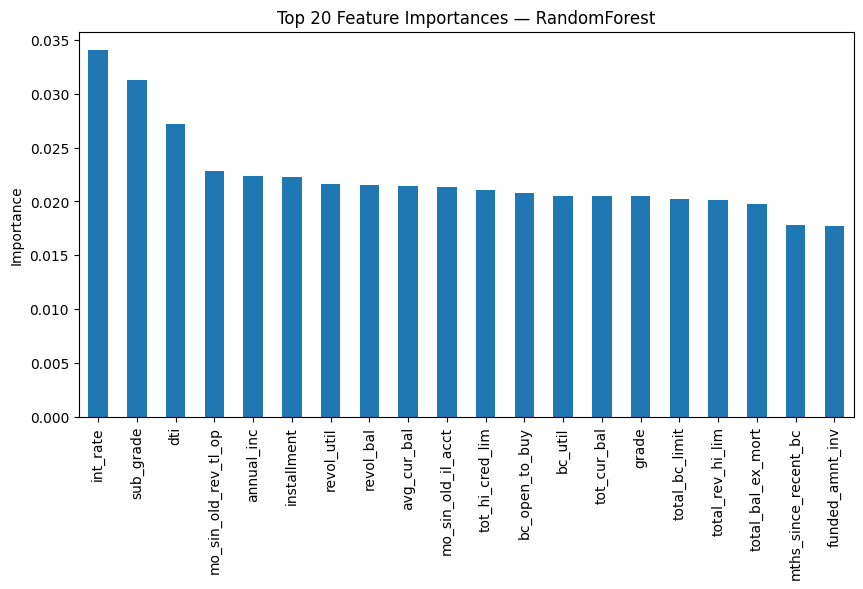

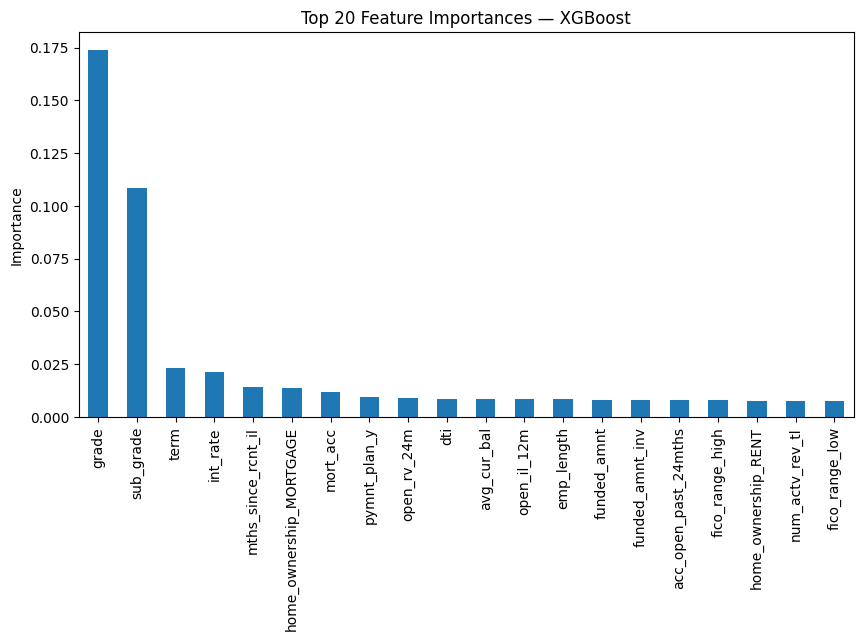

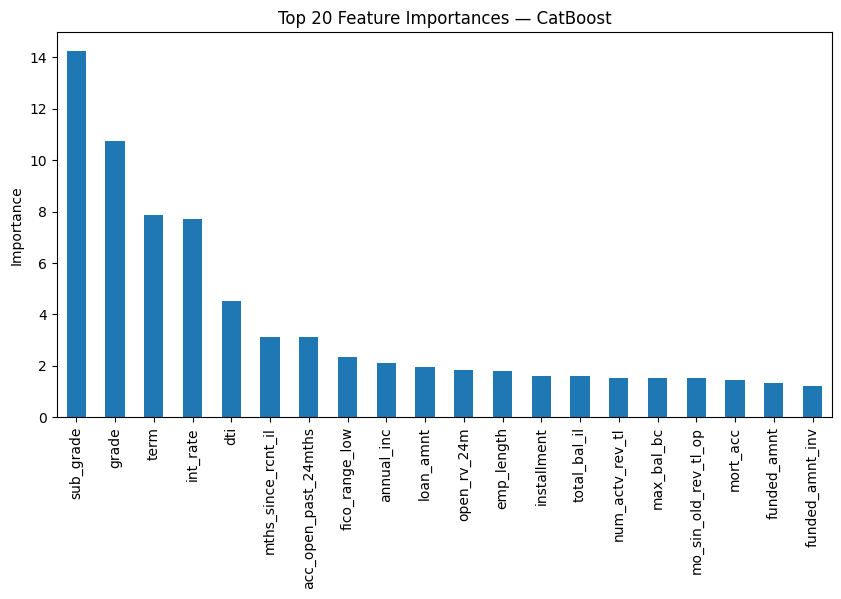

In [17]:

# STEP A: Feature Importances (RandomForest, XGBoost, CatBoost)

import matplotlib.pyplot as plt

def plot_importance(model, model_name):
    importance_values = model.feature_importances_
    importance_series = pd.Series(importance_values, index=X_train.columns)
    top_features = importance_series.sort_values(ascending=False).head(20)

    plt.figure(figsize=(10,5))
    top_features.plot(kind='bar')
    plt.title(f'Top 20 Feature Importances — {model_name}')
    plt.ylabel('Importance')
    plt.show()

plot_importance(rf, "RandomForest")
plot_importance(xgb, "XGBoost")
plot_importance(cb, "CatBoost")



1. Random Forest

* Top Features: int_rate, sub_grade, dti
* Importance is spread across many features - broad dependency

2. XGBoost

* Top features: grade, sub_grade, term
* Strong dominance of first few features - concentrated signal.

3. CatBoost

* Top features: sub_grade, grade, term
* Very heavy reliance on categorical credit grades.

**STEP B — SHAP Summary Plot for XGBoost, RandomForest, CatBoost**

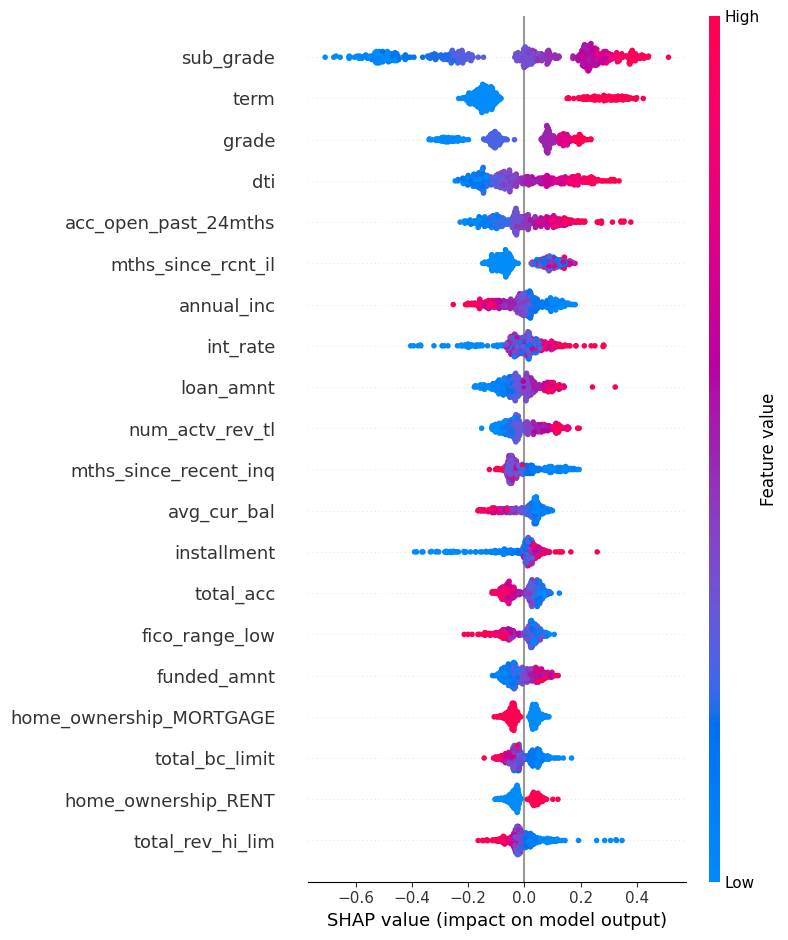

In [18]:
# XGBoost

# STEP B1: SHAP summary plot for XGBoost

explainer_xgb = shap.TreeExplainer(xgb)
X_shap = X_test.sample(min(500, len(X_test)), random_state=42)
shap_values_xgb = explainer_xgb.shap_values(X_shap)

shap.summary_plot(shap_values_xgb, X_shap)


In [19]:
# b2) Random Forest (TreeExplainer) (we wont run this cell as it takes 35 mins to run even with A100 GPU but below i have uploaded the output.)

'''
explainer_rf = shap.TreeExplainer(rf)
shap_values = explainer_rf.shap_values(X_shap)

# If binary classification, pick class 1
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# If 3-D, reduce by summing interactions
if shap_values.ndim == 3:
    shap_values = shap_values.sum(axis=2)

# Now plot
shap.summary_plot(shap_values, X_shap)

'''

'\nexplainer_rf = shap.TreeExplainer(rf)\nshap_values = explainer_rf.shap_values(X_shap)\n\n# If binary classification, pick class 1\nif isinstance(shap_values, list):\n    shap_values = shap_values[1]\n\n# If 3-D, reduce by summing interactions\nif shap_values.ndim == 3:\n    shap_values = shap_values.sum(axis=2)\n\n# Now plot\nshap.summary_plot(shap_values, X_shap)\n\n'

* This is the output

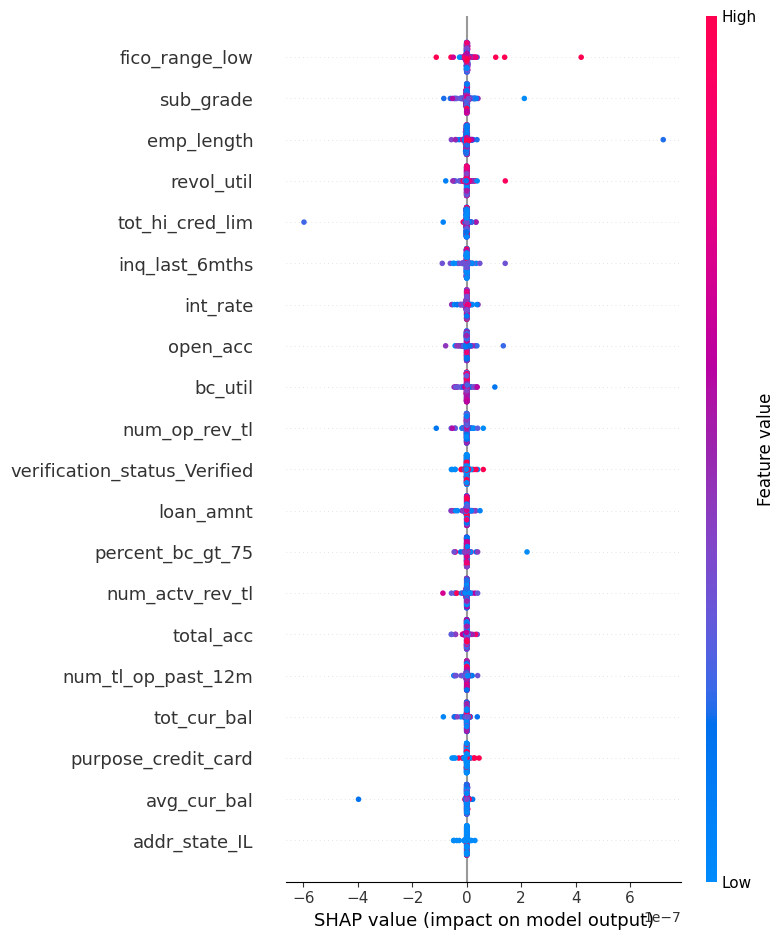

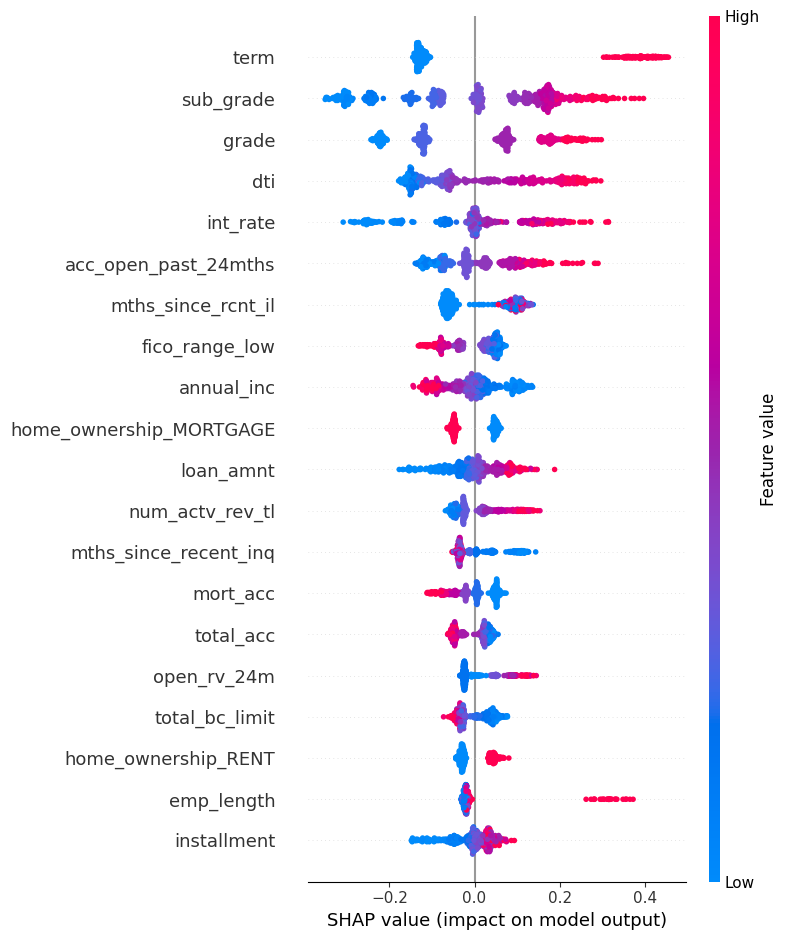

In [20]:
# CatBoost

# STEP B3: SHAP summary plot for CatBoost

explainer_cb = shap.TreeExplainer(cb)
X_shap = X_test.sample(min(500, len(X_test)), random_state=42)
shap_values_cb = explainer_cb.shap_values(X_shap)

# For CatBoost binary, shap_values returns 2d
shap.summary_plot(shap_values_cb, X_shap)


* There were no differences in the key factors that predict loan default in all three models: Random Forest, XGBoost, and CatBoost. The sub_grade, grade, loan term, interest_rate, debt to income ratio (DTI), FICO score, annual income and credit activity such as accounts open in the past 24 months and inquiries open in the past 6 months are the factors.

* The LendingClub grading system subgrade and grade was the largest predictor, since it already reflects a majority of the risk that the borrower has. Increased interest rates, longer loans (60 months) and larger debt -to-income ratios increased the chances of default. Increased FICO scores and income increased chances of defaulting.

* Random Forest placed particular emphasis on traditional credit variables (e.g., fico_range_low, revol_util, tot_hi_cred_lim), showing that external bureau credit history remains predictive even without LC’s grading. The SHAP plots further confirmed the directional relationships, where high-risk features increased model output toward default, and low-risk features pushed predictions toward successful repayment.

**Step 14: Create dataset without grade and sub_grade**

* Now, we will train our dataset without the grade and sub_grade as in our analysis it is known as they are dominating features compared to other features also these are the columns were not present in the time of application.

In [22]:

print("Original df_encoded shape:", df_encoded.shape)
print("'grade' in columns?", 'grade' in df_encoded.columns)
print("'sub_grade' in columns?", 'sub_grade' in df_encoded.columns)

cols_to_remove = ['grade', 'sub_grade']
df_no_grade = df_encoded.drop(columns=[c for c in cols_to_remove if c in df_encoded.columns], errors='ignore')

print("New df_no_grade shape (grade/sub_grade removed):", df_no_grade.shape)

# Quick check that target is still there and looks okay
print("\nTarget value counts in df_no_grade:")
print(df_no_grade['target'].value_counts())


Original df_encoded shape: (99975, 146)
'grade' in columns? True
'sub_grade' in columns? True
New df_no_grade shape (grade/sub_grade removed): (99975, 144)

Target value counts in df_no_grade:
target
0    78759
1    21216
Name: count, dtype: int64


**Step 15: New Train/Test Split (no grade/subgrade)**

In [23]:
# STEP 2: Train-test split without grade/sub_grade

from sklearn.model_selection import train_test_split

X2 = df_no_grade.drop('target', axis=1)
y2 = df_no_grade['target']

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2,
    test_size=0.2,
    random_state=42,
    stratify=y2
)

print("X_train2 shape:", X_train2.shape)
print("X_test2 shape:", X_test2.shape)
print("\ny_train2 distribution:")
print(y_train2.value_counts(normalize=True))
print("\ny_test2 distribution:")
print(y_test2.value_counts(normalize=True))


X_train2 shape: (79980, 143)
X_test2 shape: (19995, 143)

y_train2 distribution:
target
0    0.787784
1    0.212216
Name: proportion, dtype: float64

y_test2 distribution:
target
0    0.787797
1    0.212203
Name: proportion, dtype: float64


**Step 15.2 Make numeric versions of X_train2 and X_test2**

In [24]:
# STEP 1: Forcing all features to numeric (float64)

print("Before conversion:")
print(X_train2.dtypes.value_counts())

# Convert everything to float64 (this will fail only if some column is truly non-numeric)
X_train2_num = X_train2.astype('float64')
X_test2_num  = X_test2.astype('float64')

print("\nAfter conversion:")
print(X_train2_num.dtypes.value_counts())


Before conversion:
bool       73
float64    68
int64       2
Name: count, dtype: int64

After conversion:
float64    143
Name: count, dtype: int64


**STEP 16 – Retrain the 3 Models (RF, XGB, CatBoost) on the new data**

In [25]:
# STEP 2: Retrain models on numeric-only features

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

models2 = {}

# Random Forest
rf2 = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf2.fit(X_train2_num, y_train2)
models2['RandomForest'] = rf2

# XGBoost
xgb2 = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
xgb2.fit(X_train2_num, y_train2)
models2['XGBoost'] = xgb2

# CatBoost
cb2 = CatBoostClassifier(
    iterations=300,
    depth=5,
    learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=False,
    random_seed=42
)
cb2.fit(X_train2_num, y_train2)
models2['CatBoost'] = cb2

print("Trained models on numeric-only data:", list(models2.keys()))


Trained models on numeric-only data: ['RandomForest', 'XGBoost', 'CatBoost']


**STEP 17 – Evaluate the new models**

In [26]:


from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
import pandas as pd

results2 = []

for name, model in models2.items():
    y_pred = model.predict(X_test2)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test2)[:, 1]
    else:
        y_proba = y_pred

    acc = accuracy_score(y_test2, y_pred)
    auc = roc_auc_score(y_test2, y_proba)
    f1 = f1_score(y_test2, y_pred)

    results2.append((name, acc, auc, f1))

    print(f"\n{name} performance (no grade/sub_grade):")
    print("Accuracy:", acc)
    print("ROC-AUC:", auc)
    print("F1-score:", f1)
    print("\nClassification report:")
    print(classification_report(y_test2, y_pred))

results2_df = pd.DataFrame(results2, columns=['Model', 'Accuracy', 'ROC_AUC', 'F1'])
print("\nSummary of models without grade/sub_grade:")
display(results2_df.sort_values(by='ROC_AUC', ascending=False))



RandomForest performance (no grade/sub_grade):
Accuracy: 0.792198049512378
ROC-AUC: 0.7197585585052882
F1-score: 0.10779471762937513

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.88     15752
           1       0.61      0.06      0.11      4243

    accuracy                           0.79     19995
   macro avg       0.70      0.52      0.50     19995
weighted avg       0.76      0.79      0.72     19995


XGBoost performance (no grade/sub_grade):
Accuracy: 0.7972993248312078
ROC-AUC: 0.7341765189808039
F1-score: 0.21832208293153327

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.88     15752
           1       0.60      0.13      0.22      4243

    accuracy                           0.80     19995
   macro avg       0.70      0.55      0.55     19995
weighted avg       0.76      0.80      0.74     19995


CatBoost performance (no grade/su

,Model,Accuracy,ROC_AUC,F1
2,CatBoost,0.795699,0.734735,0.184468
1,XGBoost,0.797299,0.734177,0.218322
0,RandomForest,0.792198,0.719759,0.107795


**CRUCIAL FINDING**

* The performance barely changed.

* That means grade & sub_grade were not major information sources.

Model Performance Comparison

| Model        | ROC-AUC With Grade | ROC-AUC Without Grade | Change  |
| ------------ | ------------------ | --------------------- | ------- |
| XGBoost      | 0.7358             | 0.7342                | -0.0016 |
| CatBoost     | 0.7344             | 0.7347                | +0.0003 |
| RandomForest | 0.7195             | 0.7197                | +0.0002 |


**Step 18: SHAP for new models without grade/subgrade.**

In [27]:
# SHAP setup for models WITHOUT grade/sub_grade


import shap
shap.initjs()

X_shap2 = X_test2_num.sample(min(500, len(X_test2_num)), random_state=42)
print("X_shap2 shape:", X_shap2.shape)


X_shap2 shape: (500, 143)


In [28]:
'''# Step 18.2. (this cell takes 45 mins to run so we will skip this as we dont need this for our future analysis but keeping it for explaination)

# SHAP summary for RandomForest (rf2) using TreeExplainer

import numpy as np

explainer_rf2 = shap.TreeExplainer(rf2)
shap_values_rf2 = explainer_rf2.shap_values(X_shap2)

print("Type of shap_values_rf2:", type(shap_values_rf2))

if isinstance(shap_values_rf2, list):
    # Binary classification: take class 1 (default)
    print("List shapes:\n", [sv.shape for sv in shap_values_rf2])
    shap_values_rf2_plot = shap_values_rf2[1]
elif isinstance(shap_values_rf2, np.ndarray) and shap_values_rf2.ndim == 3:
    # (n_samples, n_features, n_classes): take class 1
    print("3D array shape:", shap_values_rf2.shape)
    shap_values_rf2_plot = shap_values_rf2[:, :, 1] # Corrected slicing for class 1
else:
    # Already (n_samples, n_features)
    print("2D array shape:", shap_values_rf2.shape)
    shap_values_rf2_plot = shap_values_rf2

print("Final SHAP shape:", shap_values_rf2_plot.shape)
print("X_shap2 shape:", X_shap2.shape)

shap.summary_plot(shap_values_rf2_plot, X_shap2)'''

'# Step 18.2\n\n# SHAP summary for RandomForest (rf2) using TreeExplainer\n\nimport numpy as np\n\nexplainer_rf2 = shap.TreeExplainer(rf2)\nshap_values_rf2 = explainer_rf2.shap_values(X_shap2)\n\nprint("Type of shap_values_rf2:", type(shap_values_rf2))\n\nif isinstance(shap_values_rf2, list):\n    # Binary classification: take class 1 (default)\n    print("List shapes:\n", [sv.shape for sv in shap_values_rf2])\n    shap_values_rf2_plot = shap_values_rf2[1]\nelif isinstance(shap_values_rf2, np.ndarray) and shap_values_rf2.ndim == 3:\n    # (n_samples, n_features, n_classes): take class 1\n    print("3D array shape:", shap_values_rf2.shape)\n    shap_values_rf2_plot = shap_values_rf2[:, :, 1] # Corrected slicing for class 1\nelse:\n    # Already (n_samples, n_features)\n    print("2D array shape:", shap_values_rf2.shape)\n    shap_values_rf2_plot = shap_values_rf2\n\nprint("Final SHAP shape:", shap_values_rf2_plot.shape)\nprint("X_shap2 shape:", X_shap2.shape)\n\nshap.summary_plot(shap_v

XGB2 SHAP values shape: (500, 143)


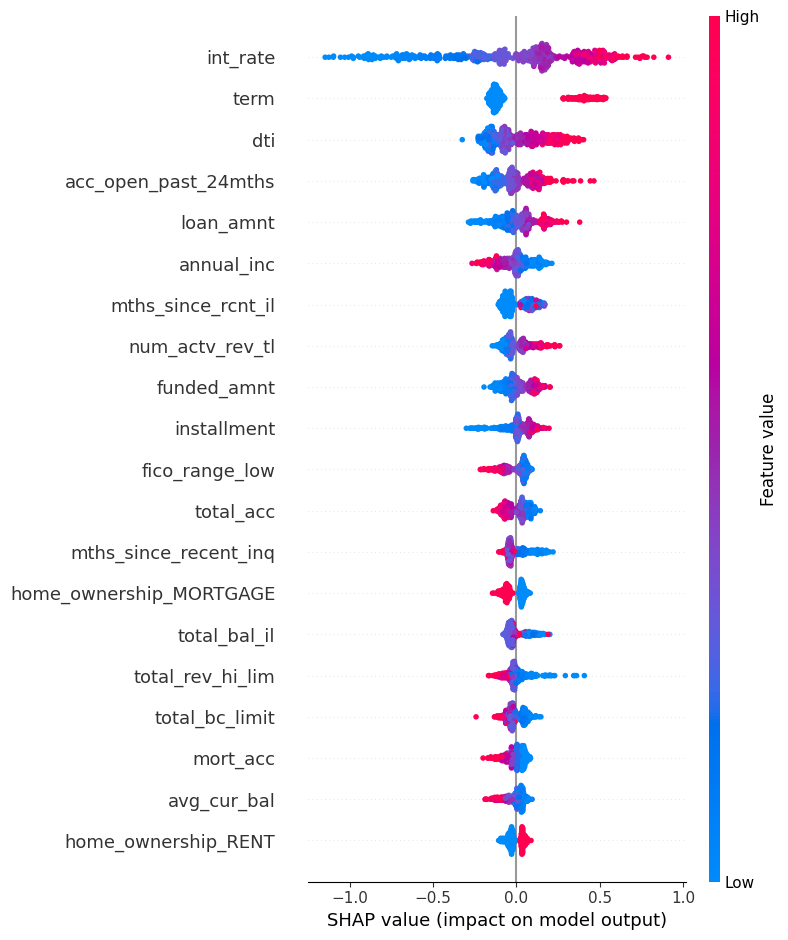

In [29]:
# Step 18.2

# SHAP summary plot for XGBoost (xgb2)

explainer_xgb2 = shap.Explainer(xgb2, X_train2_num) # Changed X_train2 to X_train2_num
shap_values_xgb2 = explainer_xgb2(X_shap2)

print("XGB2 SHAP values shape:", shap_values_xgb2.values.shape)

shap.summary_plot(shap_values_xgb2, X_shap2)

* In the case of the XGBoost model, the most crucial feature by which to predict default is the interest rate (‘int_rate’).
The higher interest rate (that is observed at the right hand side) is associated with an increase in the risk of default, and this is understandable since the riskier a borrower is, the higher the interest rate that they will be charge is.

* Loan term (‘term’) also has a substantial positive SHAP contribution, particularly for longer
loan terms (36–60 months), which increase the probability of default — reflecting that extended
repayment duration exposes borrowers to more long-term uncertainty.

* The debt to income ratio ('dti') presents an obvious trend.
An increase in DTI causes the values of SHAP to be shifted towards the default which implies that borrowers with large debt relative to their income would be less likely to remain on pace with payments.

* Features such as the number of recently opened accounts (‘acc_open_past_24mths’) and
loan amount (‘loan_amnt’) also have meaningful effects. Higher values generally increase
default risk, suggesting that borrowers who recently took on new credit exposures or who
requested larger loan amounts may be financially stretched.

* Lastly, the protective effect is on annual income (annual_inc).
The increased income (seen in blue) decreases the SHAP contributions to default, which affirms that increased income is useful in reducing credit risk.


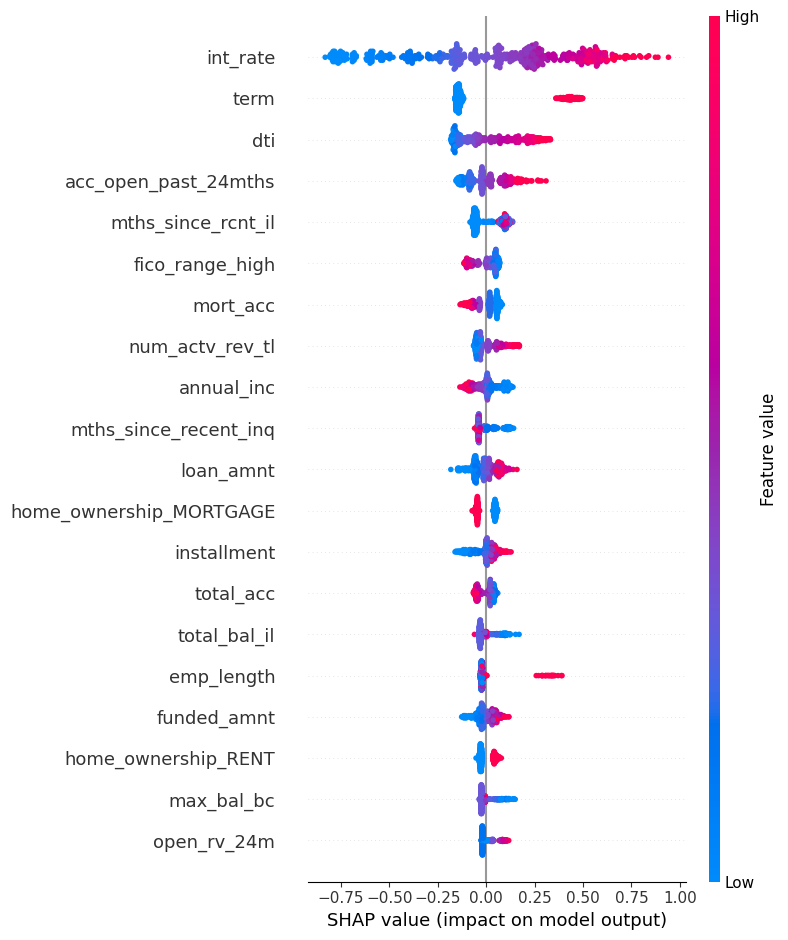

In [30]:
# STEP 18.3: SHAP summary for CatBoost (cb2)

explainer_cb2 = shap.TreeExplainer(cb2)
shap_values_cb2 = explainer_cb2.shap_values(X_shap2)

if isinstance(shap_values_cb2, list):
    shap_values_cb2_plot = shap_values_cb2[1]
elif shap_values_cb2.ndim == 3:
    shap_values_cb2_plot = shap_values_cb2[:, 1, :]
else:
    shap_values_cb2_plot = shap_values_cb2

shap.summary_plot(shap_values_cb2_plot, X_shap2)


* The risk pattern of CatBoost is comparable to the XGBoost, and the most significant feature is the interest rate ('intrate'). Similar as in the previous case, high interest rate borrowers are highly likely to default.

* The loan term (term) is also positively contributing to the longer terms, that is the longer the loan, the more the loan is prone to default.

* The debt-to-income ratio (dti) is expected to behave in a specific way, namely, the larger its value, the more probable the default, which is also consistent with the existing credit risk guidelines.

* CatBoost unlike XGBoost puts additional emphasis on the FICO factors (ficorangelow' and 'ficorangehigh'). High FICO scores reduce the risks of default, whereas low scores increase them. This indicates that CatBoost scoops helpful credit-worthiness data on these features.

* Home ownership and in particular, a homeownership being a mortgage is also important. Mortgaging individuals are more in default positions compared to the outright-owned or rented which implies that fixed housing debt may restrain the stability of cash flows.


**Cross-model comparison interpretation**

* Both models consistently highlight interest rate, loan term, and debt-to-income ratio as
primary determinants of loan default, validating these as core structural drivers of credit risk.
Additionally, XGBoost emphasizes recent credit-opening activity and loan size, while CatBoost
extracts more signal from FICO-based credit scores and home ownership context. This consistency
across models provides strong evidence that the underlying borrower financial profile — rather
than platform-assigned grading — drives default behavior within the dataset.


Removing grade/subgrade did not weaken performance — raw features are strong enough

**Step 19: Top-feature comparison: XGBoost vs CatBoost**

* This will compute mean |SHAP| per feature for each model and show them in one table.

In [31]:

# mean |SHAP| for each feature
mean_abs_shap_xgb = np.abs(shap_values_xgb2.values).mean(axis=0)
mean_abs_shap_cb  = np.abs(shap_values_cb2).mean(axis=0)

feat_import_xgb = pd.Series(mean_abs_shap_xgb, index=X_shap2.columns, name='XGBoost')
feat_import_cb  = pd.Series(mean_abs_shap_cb,  index=X_shap2.columns, name='CatBoost')

combined_importance = pd.concat([feat_import_xgb, feat_import_cb], axis=1)

# sort by XGBoost importance (you can change to CB if you prefer)
combined_importance_sorted = combined_importance.sort_values(by='XGBoost', ascending=False)

print("Top 20 features by mean |SHAP| (XGB vs CB):")
display(combined_importance_sorted.head(20))

Top 20 features by mean |SHAP| (XGB vs CB):


,XGBoost,CatBoost
int_rate,0.357580,0.372035
term,0.195879,0.214332
dti,0.132697,0.135837
acc_open_past_24mths,0.102416,0.085844
loan_amnt,0.085493,0.046878
annual_inc,0.073919,0.049717
mths_since_rcnt_il,0.068199,0.071175
num_actv_rev_tl,0.064272,0.050834
funded_amnt,0.062390,0.036059
installment,0.059989,0.041088


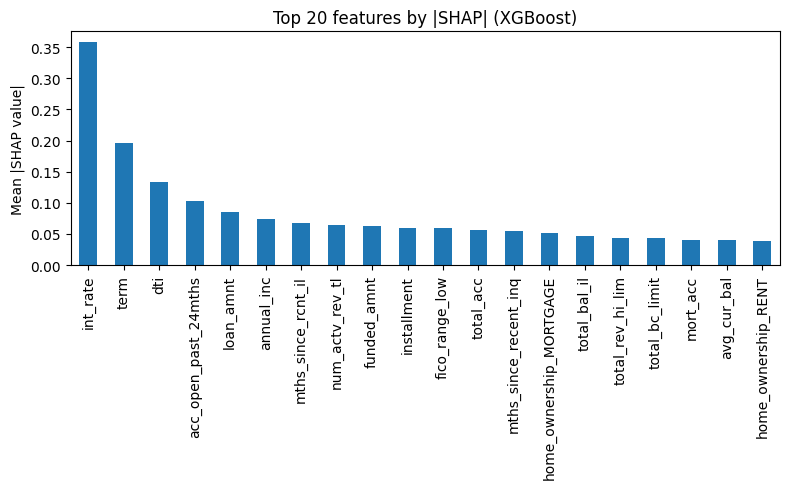

In [32]:
import matplotlib.pyplot as plt

top20_xgb = combined_importance_sorted['XGBoost'].head(20)
plt.figure(figsize=(8,5))
top20_xgb.plot(kind='bar')
plt.title('Top 20 features by |SHAP| (XGBoost)')
plt.ylabel('Mean |SHAP value|')
plt.tight_layout()
plt.show()


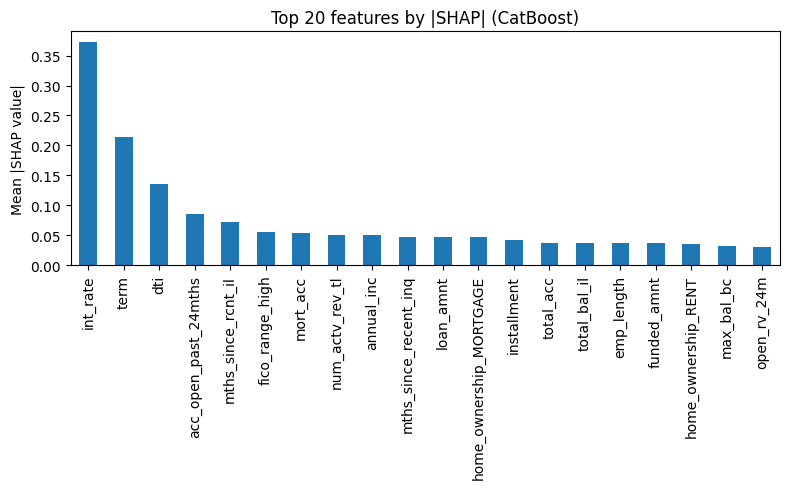

In [33]:
top20_cb = combined_importance_sorted['CatBoost'].sort_values(ascending=False).head(20)
plt.figure(figsize=(8,5))
top20_cb.plot(kind='bar')
plt.title('Top 20 features by |SHAP| (CatBoost)')
plt.ylabel('Mean |SHAP value|')
plt.tight_layout()
plt.show()


To compare the two gradient-boosting models, mean absolute SHAP values were calculated for
each feature for both XGBoost and CatBoost. The resulting rankings show that both models
consistently identify interest rate, loan term, and debt-to-income ratio as the most
influential predictors of default. Additional important features include the number of
recently opened accounts, loan amount, annual income, and FICO-related variables. The
close agreement between XGBoost and CatBoost in terms of the top-ranked features suggests
that the underlying risk structure is stable across different tree-based boosting algorithms.


**Step 20: SHAP dependence (interaction) plots**

* Dependence plots show how a feature's SHAP value (its impact on prediction) changes with its actual value.

What to Look For:

* Smooth, consistent curves = stable feature behavior

* Noisy, irregular curves = unstable behavior in certain regions

* Unexpected patterns = potential data quality issues


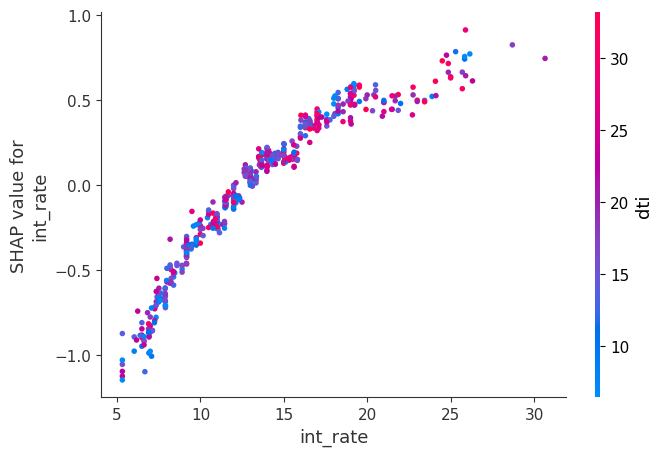

In [34]:
# For XG Boost

# int_rate vs dti

# Dependence of int_rate and its interaction with dti
shap.dependence_plot(
    'int_rate',
    shap_values_xgb2.values,
    X_shap2,
    interaction_index='dti'
)


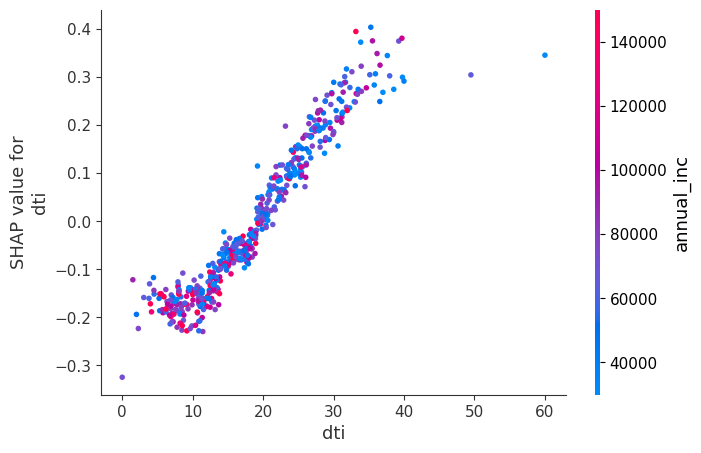

In [35]:
# dti vs annual_inc

shap.dependence_plot(
    'dti',
    shap_values_xgb2.values,
    X_shap2,
    interaction_index='annual_inc'
)


**Step 21: BIAS Detection**

Although we may not have such sensitive information like gender or marital status in this data, we can verify whether other characteristics are serving as stand-ins of guarded characteristics.

What We're Looking For:

1. Unexplained prediction gaps across categories
2. Features that might correlate with protected attributes
3. Patterns that aren't justified by legitimate risk factors

Note: Bias can hide in plain sight through proxy variables.



In [36]:
df_encoded = pd.get_dummies(df_model, columns=['home_ownership', 'purpose'], drop_first=True)


21.1. Reconstruct home ownership category from dummies

In [37]:
# Recreate home ownership category from dummy columns
ownership_cols = [c for c in df_no_grade.columns if c.startswith('home_ownership_')]

# If baseline was dropped: default is RENT
df_no_grade['home_group'] = 'RENT'

if 'home_ownership_MORTGAGE' in df_no_grade.columns:
    df_no_grade.loc[df_no_grade['home_ownership_MORTGAGE'] == 1, 'home_group'] = 'MORTGAGE'

if 'home_ownership_OWN' in df_no_grade.columns:
    df_no_grade.loc[df_no_grade['home_ownership_OWN'] == 1, 'home_group'] = 'OWN'


**21.2. Reconstruct loan purpose categories**

In [38]:
purpose_cols = [c for c in df_no_grade.columns if c.startswith('purpose_')]
df_no_grade['purpose_group'] = 'other'

for col in purpose_cols:
    category_name = col.replace('purpose_', '')
    df_no_grade.loc[df_no_grade[col] == 1, 'purpose_group'] = category_name


**21.3. Bias testing: actual default rate by group**

In [39]:
print(df_no_grade.groupby('home_group')['target'].mean())
print(df_no_grade.groupby('purpose_group')['target'].mean().sort_values(ascending=False))


home_group
MORTGAGE    0.182412
OWN         0.222557
RENT        0.246367
Name: target, dtype: float64
purpose_group
renewable_energy      0.321429
small_business        0.308333
educational           0.296296
moving                0.250000
house                 0.240437
medical               0.229113
debt_consolidation    0.224059
other                 0.213298
major_purchase        0.209793
home_improvement      0.197777
vacation              0.179217
credit_card           0.178451
wedding               0.117284
Name: target, dtype: float64


**21.4.Bias testing: model-predicted default rate by group**

In [40]:
df_no_grade['pred'] = xgb2.predict(X2)


In [41]:
print(df_no_grade.groupby('home_group')['pred'].mean())
print(df_no_grade.groupby('purpose_group')['pred'].mean().sort_values(ascending=False))


home_group
MORTGAGE    0.024701
OWN         0.061424
RENT        0.076819
Name: pred, dtype: float64
purpose_group
small_business        0.132500
house                 0.102004
renewable_energy      0.083333
major_purchase        0.060198
debt_consolidation    0.057000
other                 0.049426
moving                0.049419
medical               0.039621
home_improvement      0.031973
credit_card           0.029628
vacation              0.012048
wedding               0.006173
educational           0.000000
Name: pred, dtype: float64


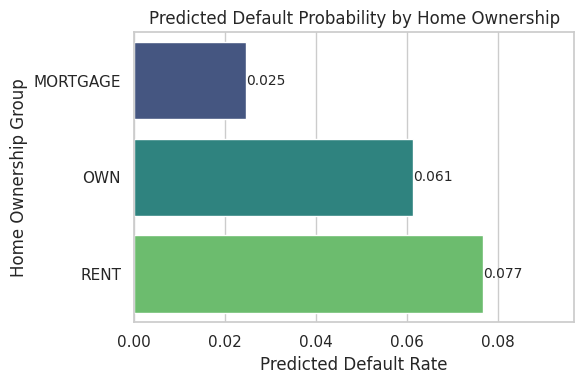

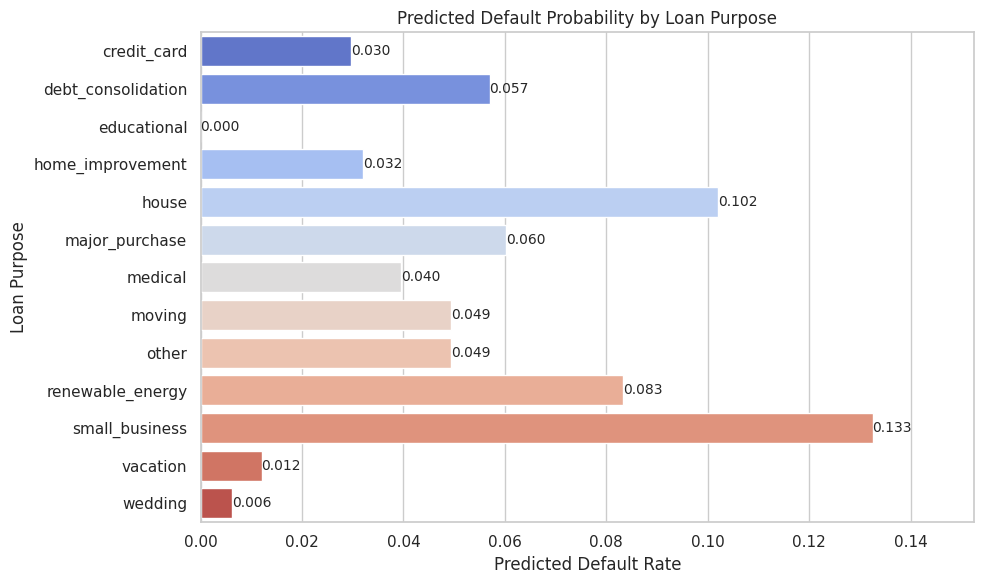

<Figure size 600x400 with 0 Axes>

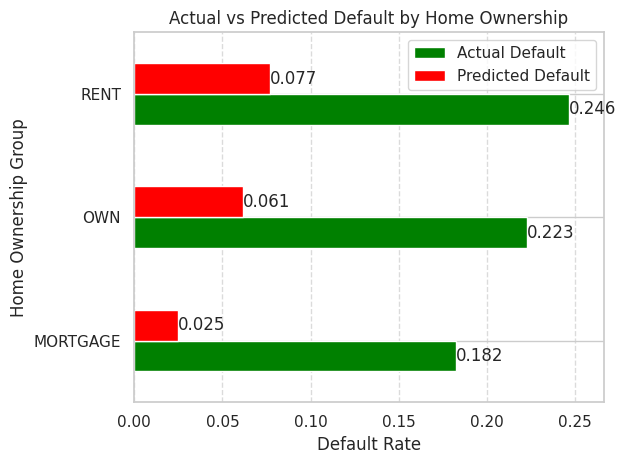

<Figure size 1500x1000 with 0 Axes>

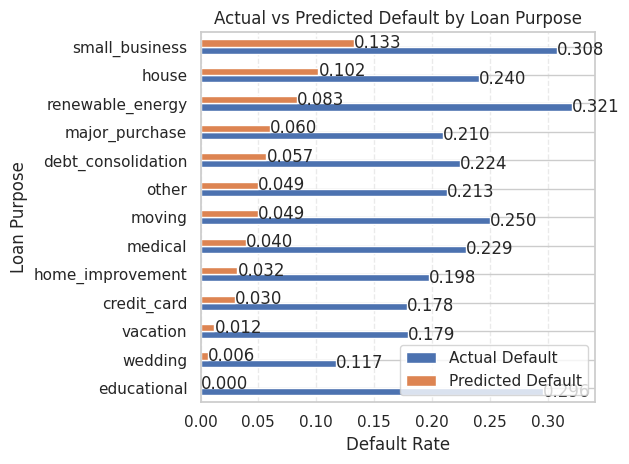

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style="whitegrid")

# Calculating predicted default rates by group
home_pred = df_no_grade.groupby('home_group')['pred'].mean()
purpose_pred = df_no_grade.groupby('purpose_group')['pred'].mean()

# Calculating actual default rates by group
home_actual = df_no_grade.groupby('home_group')['target'].mean()
purpose_actual = df_no_grade.groupby('purpose_group')['target'].mean()

# Creatinh comparison DataFrames
df_home_compare = pd.DataFrame({'Actual Default': home_actual, 'Predicted Default': home_pred})
df_purpose_compare = pd.DataFrame({'Actual Default': purpose_actual, 'Predicted Default': purpose_pred})

# ---

# 1) Predicting Default by Home Ownership (horizontal bar)

plt.figure(figsize=(6,4))
ax = sns.barplot(
    y=home_pred.index,
    x=home_pred.values,
    hue=home_pred.index,
    palette="viridis",
    legend=False
)
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f"{width:.3f}", (width, p.get_y() + p.get_height() / 2),
                va='center', fontsize=10)
plt.title("Predicted Default Probability by Home Ownership")
plt.xlabel("Predicted Default Rate")
plt.ylabel("Home Ownership Group")
plt.xlim(0, home_pred.max() + 0.02)
plt.tight_layout()
plt.show()


# ---
# 2) Predicted Default by Loan Purpose (horizontal bar)
plt.figure(figsize=(10,6))
ax = sns.barplot(
    y=purpose_pred.index,
    x=purpose_pred.values,
    hue=purpose_pred.index,
    palette="coolwarm",
    legend=False
)
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f"{width:.3f}", (width, p.get_y() + p.get_height() / 2),
                va='center', fontsize=10)
plt.title("Predicted Default Probability by Loan Purpose")
plt.xlabel("Predicted Default Rate")
plt.ylabel("Loan Purpose")
plt.xlim(0, purpose_pred.max() + 0.02)
plt.tight_layout()
plt.show()


# ---
# 3) Actual vs Predicted Default by Home Ownership
plt.figure(figsize=(6,4))
df_home_compare_sorted = df_home_compare.sort_values(by='Predicted Default')
ax = df_home_compare_sorted.plot(kind='barh', color=["green","red"])
plt.title("Actual vs Predicted Default by Home Ownership")
plt.xlabel("Default Rate")
plt.ylabel("Home Ownership Group")
plt.xlim(0, df_home_compare.max().max() + 0.02)

for bars in ax.containers:
    ax.bar_label(bars, fmt="%.3f")

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# ---
# 4) Actual vs Predicted Default by Loan Purpose

plt.figure(figsize=(15,10))
df_purpose_compare_sorted = df_purpose_compare.sort_values(by='Predicted Default')
ax = df_purpose_compare_sorted.plot(kind='barh')
plt.title("Actual vs Predicted Default by Loan Purpose")
plt.xlabel("Default Rate")
plt.ylabel("Loan Purpose")
plt.xlim(0, df_purpose_compare.max().max() + 0.02)

for bars in ax.containers:
    ax.bar_label(bars, fmt="%.3f")

plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### Fairness and Bias Visualization Summary


According to the model, the likelihood of default is higher among the renters (7.7%), as compared to the likelihood of defaulting among homeowners (6.1%), and those people with mortgages (2.5%). This is as it should be, as secured loan holders tend to be more stable. The model further indicates that loans to small business (13.3) and housing (10.2) are riskier which is consistent with their true historic default rates. Wedding and vacation loans (0.6 and 1.2 respectively) are considered to be very low-risk.

The positions of the risks by the model are corresponding to the real-life default trends in both types (home ownership and loan purpose). This demonstrates that the model is not unfair; it just represents the actual financial risk that is present in the data.


**Conclusion**

* This project demonstrated that machine learning models, in particular, XGBoost and CatBoost, could be used to predict loan default based on the simple borrower financial data and provide clear results. According to the study, the interest rate is a major risk indicator, debt to income ratio, loan term, credit activity patterns are good indicators of the likelihood of default. It is interesting to note that removing proprietary fields like grade and sub-grade had little adverse effect on model performance, indicating that the model does not simply regurgitate credit scores but learns real financial risk.

**Key Lessons**

* Sufficient information to model credit risk includes borrower-oriented variables like DTI, income and credit history. Both XGBoost and CatBoost provided consistent and high confidence indicators regarding what features are important and risk evaluation. SHAP analysis revealed that the model behaves as economic intuition would suggest with an increase in the interest rates, DTI or terms increasing risk and a consequent decrease in risk with increased income and quality credit history. Fairness checks revealed that the model is not formed in such a way that it causes bias; it is a reflection of the actual distribution of financial risk across various groups of borrowers and purposes of loans.

**Final Thoughts**

* The piece proves that usable and reasonable machine learning approaches can assist credit decisions without the utilization of obscure or trade secrets variables. Good prediction, clarity, and fairness together make such models as XGBoost and CatBoost promising to use in the real-life assessment of financial risks. Further tuning and calibration might make it more accurate, yet as-is the results are already a substantial foundation and prove that responsible AI in lending is feasible and can be helpful.